# H&M Article Features - Exploratory Data Analysis

This notebook performs comprehensive EDA on the engineered article features dataset to understand:

- Product catalogue characteristics and diversity
- Feature engineering quality and distributions
- Product category patterns and relationships
- Text-based feature insights (BERT/TF-IDF embeddings)
- Product performance indicators and clustering opportunities


## 1. Setup and Data Loading


In [1]:
# Import required libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy import stats
from collections import Counter

# Add project root to path
import sys
project_root = Path.cwd().parent.parent  # Go up two levels from notebooks/eda_notebooks/
sys.path.append(str(project_root))

try:
    from hnm_data_analysis.exploratory_data_analysis.eda_module import EDAModule
    print("✅ EDA module imported successfully")
except ImportError as e:
    print(f"⚠️ Could not import EDA module: {e}")
    print("Continuing without EDA module...")

# Configure plotting for UK publication standards
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully")

✅ EDA module imported successfully
📦 Libraries imported successfully


In [2]:
# Load article features data
data_path = "../../data/features/final/articles_features_final.parquet"
print(f"Loading article features data from: {data_path}")

try:
    df = pl.read_parquet(data_path)
    print(f"✅ Data loaded successfully: {df.shape[0]:,} articles × {df.shape[1]} features")
    print(f"Memory usage: {df.estimated_size('mb'):.1f} MB")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

Loading article features data from: ../../data/features/final/articles_features_final.parquet
✅ Data loaded successfully: 42,298 articles × 14 features
Memory usage: 2.4 MB


## 2. Dataset Structure and Quality Assessment


In [3]:
# Comprehensive dataset overview
print("📊 Article Features Dataset Overview")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Total articles: {df.height:,}")
print(f"Total features: {df.width}")
print(f"Column names: {list(df.columns)}")
print(f"Data types: {dict(zip(df.columns, [str(dtype) for dtype in df.dtypes]))}")

# Identify feature categories
categorical_features = [col for col in df.columns if 'name' in col.lower() or 'group' in col.lower()]
numeric_features = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
text_embedding_features = [col for col in df.columns if any(prefix in col for prefix in ['bert_', 'tfidf_', 'svd_', 'pca_'])]

print(f"\n🏷️ Feature Categories:")
print(f"• Categorical features: {len(categorical_features)} - {categorical_features}")
print(f"• Numeric features: {len(numeric_features)}")
print(f"• Text embedding features: {len(text_embedding_features)}")

# Display sample data
print("\n🔍 Sample Article Features:")
df.head()

📊 Article Features Dataset Overview
Shape: (42298, 14)
Total articles: 42,298
Total features: 14
Column names: ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc', 'bert_cluster']
Data types: {'article_id': 'Int64', 'product_type_name': 'Categorical(Categories(""))', 'product_group_name': 'Categorical(Categories(""))', 'graphical_appearance_name': 'Categorical(Categories(""))', 'colour_group_name': 'Categorical(Categories(""))', 'perceived_colour_value_name': 'Categorical(Categories(""))', 'perceived_colour_master_name': 'Categorical(Categories(""))', 'department_name': 'Categorical(Categories(""))', 'index_name': 'Categorical(Categories(""))', 'index_group_name': 'Categorical(Categories(""))', 'section_name': 'Categorical(Categories(""))', 'garment_group_name': 'Ca

article_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,bert_cluster
i64,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,i32
816591001,"""T-shirt""","""Garment Upper body""","""Stripe""","""Dark Blue""","""Dark""","""Blue""","""Tops Fancy Jersey""","""Divided""","""Divided""","""Divided Collection""","""Jersey Fancy""","""T-shirt in soft cotton jersey …",22
804472003,"""Sneakers""","""Shoes""","""Solid""","""Black""","""Dark""","""Black""","""Kids Boy Shoes""","""Children Accessories, Swimwear""","""Baby/Children""","""Kids & Baby Shoes""","""Shoes""","""Hi-tops in patterned imitation…",27
693915001,"""Trousers""","""Garment Lower body""","""Check""","""Beige""","""Medium Dusty""","""Beige""","""Trousers & Skirt""","""Ladieswear""","""Ladieswear""","""Womens Trend""","""Trousers""","""Trousers in woven fabric with …",9
790904007,"""Trousers""","""Garment Lower body""","""Solid""","""Beige""","""Medium Dusty""","""Beige""","""Trouser""","""Menswear""","""Menswear""","""Contemporary Casual""","""Trousers""","""Trousers in a cotton weave wit…",9
829618001,"""Bra""","""Underwear""","""Solid""","""White""","""Light""","""White""","""Expressive Lingerie""","""Lingeries/Tights""","""Ladieswear""","""Womens Lingerie""","""Under-, Nightwear""","""Push-up bra in lace with under…",15


In [4]:
# Data quality assessment
print("🔍 Data Quality Assessment")
print("=" * 40)

# Missing values analysis
quality_summary = []
for col in df.columns:
    null_count = df.select(pl.col(col).null_count()).item()
    null_pct = (null_count / df.height) * 100
    
    # Additional quality checks
    unique_count = df.select(pl.col(col).n_unique()).item()
    uniqueness_pct = (unique_count / df.height) * 100
    
    quality_summary.append({
        'Feature': col,
        'Missing Count': null_count,
        'Missing %': f"{null_pct:.2f}%",
        'Unique Values': unique_count,
        'Uniqueness %': f"{uniqueness_pct:.1f}%"
    })

quality_df = pd.DataFrame(quality_summary)
print(quality_df.to_string(index=False))

# Check for duplicates
duplicate_count = df.height - df.n_unique()
print(f"\n🔄 Duplicate article records: {duplicate_count:,}")

# Feature completeness
complete_records = df.filter(pl.all_horizontal(pl.all().is_not_null())).height
completeness_rate = (complete_records / df.height) * 100
print(f"📋 Complete feature records: {complete_records:,} ({completeness_rate:.1f}%)")

🔍 Data Quality Assessment
                     Feature  Missing Count Missing %  Unique Values Uniqueness %
                  article_id              0     0.00%          42298       100.0%
           product_type_name              0     0.00%            124         0.3%
          product_group_name              0     0.00%             18         0.0%
   graphical_appearance_name              0     0.00%             30         0.1%
           colour_group_name              0     0.00%             50         0.1%
 perceived_colour_value_name              0     0.00%              8         0.0%
perceived_colour_master_name              0     0.00%             20         0.0%
             department_name              0     0.00%            238         0.6%
                  index_name              0     0.00%             10         0.0%
            index_group_name              0     0.00%              5         0.0%
                section_name              0     0.00%             56    

## 3. Categorical Features Analysis


🏷️ Categorical Features Analysis

📊 PRODUCT_TYPE_NAME:
  Total unique values: 124
  Top 10 categories:
    Dress: 4,863 (11.5%)
    Trousers: 4,787 (11.3%)
    Sweater: 2,821 (6.7%)
    T-shirt: 2,686 (6.4%)
    Top: 1,826 (4.3%)
    Blouse: 1,775 (4.2%)
    Shorts: 1,774 (4.2%)
    Vest top: 1,412 (3.3%)
    Jacket: 1,363 (3.2%)
    Skirt: 1,310 (3.1%)

📊 PRODUCT_GROUP_NAME:
  Total unique values: 18
  Top 10 categories:
    Garment Upper body: 15,635 (37.0%)
    Garment Lower body: 8,596 (20.3%)
    Garment Full body: 5,796 (13.7%)
    Accessories: 4,179 (9.9%)
    Underwear: 2,503 (5.9%)
    Shoes: 1,947 (4.6%)
    Swimwear: 1,820 (4.3%)
    Socks & Tights: 1,005 (2.4%)
    Nightwear: 631 (1.5%)
    Unknown: 111 (0.3%)

📊 GRAPHICAL_APPEARANCE_NAME:
  Total unique values: 30
  Top 10 categories:
    Solid: 21,928 (51.8%)
    All over pattern: 6,351 (15.0%)
    Denim: 2,569 (6.1%)
    Melange: 2,161 (5.1%)
    Stripe: 1,660 (3.9%)
    Placement print: 878 (2.1%)
    Check: 878 (2.1%)


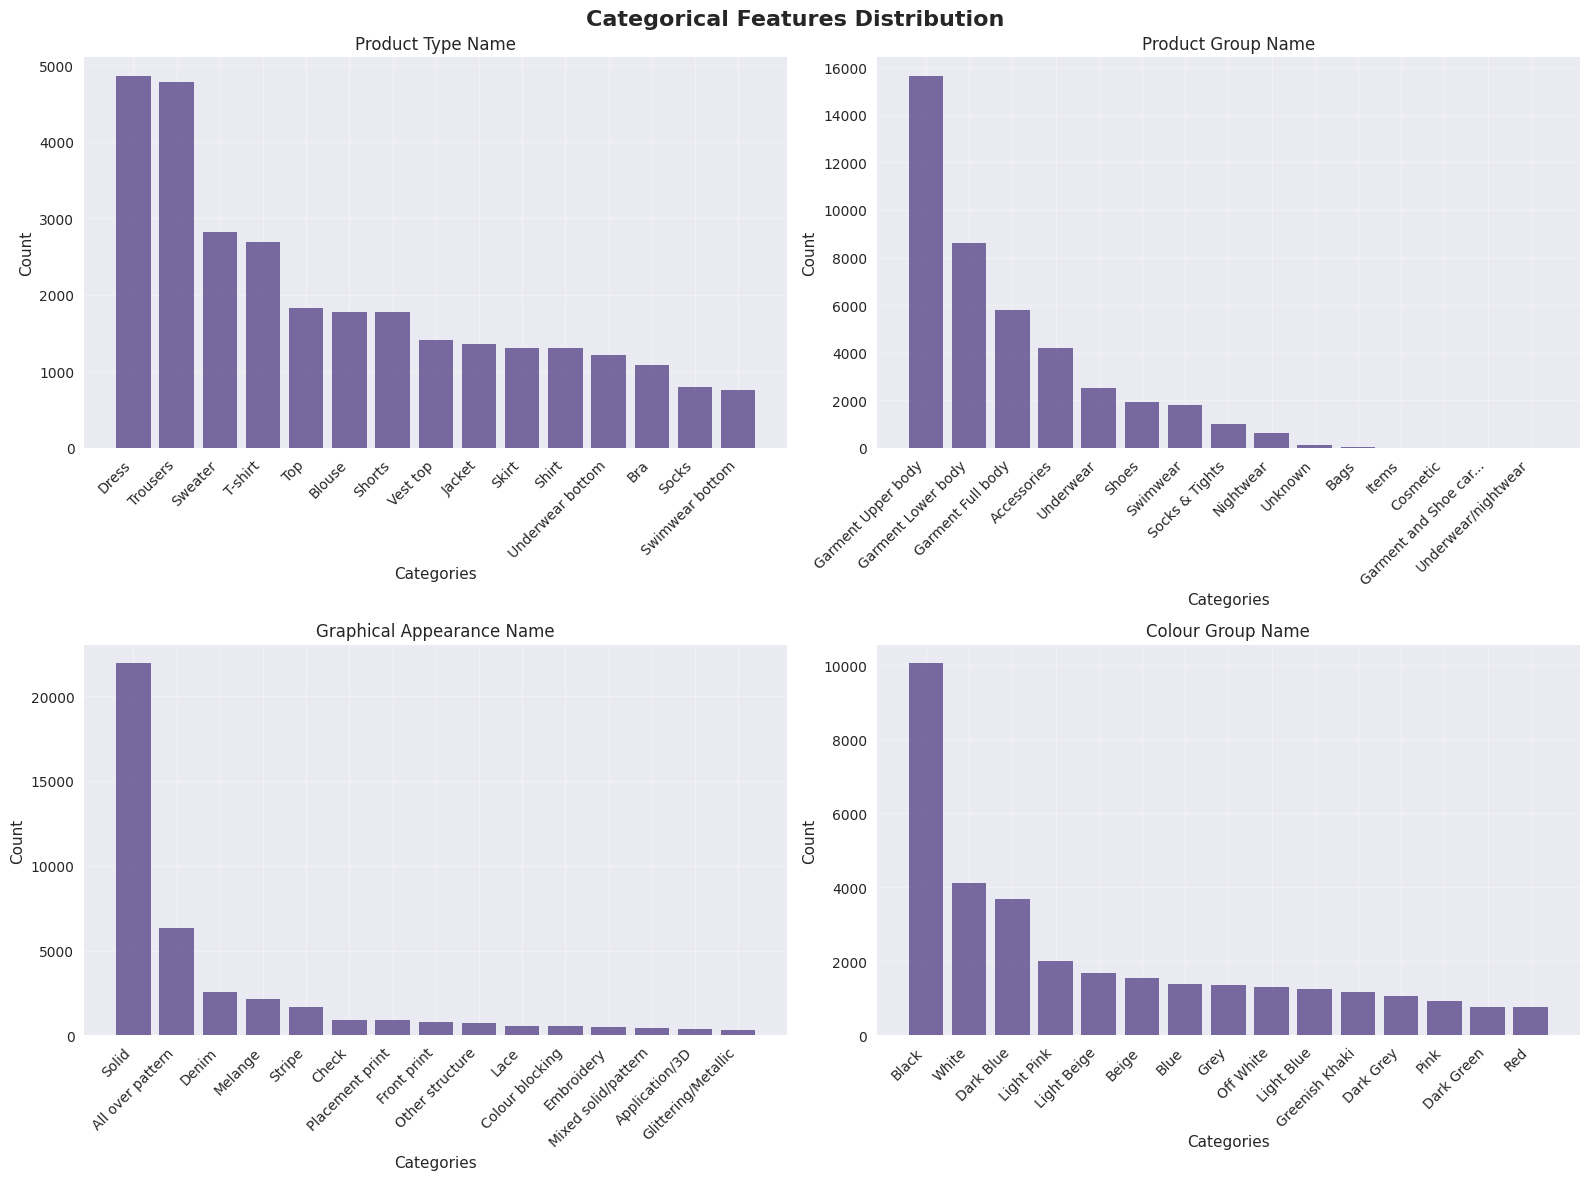

In [5]:
# Comprehensive categorical features analysis
print("🏷️ Categorical Features Analysis")

# Analyse each categorical feature
for feature in categorical_features:
    if feature in df.columns:
        print(f"\n📊 {feature.upper()}:")
        
        # Value counts and distribution
        value_counts = (
            df.group_by(feature)
            .count()
            .sort('count', descending=True)
            .head(10)
        )
        
        total_unique = df.select(pl.col(feature).n_unique()).item()
        print(f"  Total unique values: {total_unique}")
        print(f"  Top 10 categories:")
        
        for row in value_counts.iter_rows(named=True):
            percentage = (row['count'] / df.height) * 100
            print(f"    {row[feature]}: {row['count']:,} ({percentage:.1f}%)")

# Create visualisations for categorical features
if categorical_features:
    n_features = min(len(categorical_features), 4)  # Limit to 4 for display
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle('Categorical Features Distribution', fontsize=16, fontweight='bold')
    
    for i, feature in enumerate(categorical_features[:n_features]):
        if feature in df.columns:
            # Get top categories for visualisation
            top_categories = (
                df.group_by(feature)
                .count()
                .sort('count', descending=True)
                .head(15)  # Top 15 for readability
                .to_pandas()
            )
            
            # Create bar plot
            axes[i].bar(range(len(top_categories)), top_categories['count'], alpha=0.7)
            axes[i].set_title(f'{feature.replace("_", " ").title()}')
            axes[i].set_xlabel('Categories')
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
            
            # Set x-axis labels (abbreviated if too long)
            labels = [label[:20] + '...' if len(str(label)) > 20 else str(label) 
                     for label in top_categories[feature]]
            axes[i].set_xticks(range(len(top_categories)))
            axes[i].set_xticklabels(labels, rotation=45, ha='right')
    
    # Hide unused subplots
    for i in range(n_features, 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 4. Numeric Features Distribution Analysis


📈 BERT Cluster Distribution Analysis
⚠️ Missing cluster assignments: 69 articles (0.2%)
Proceeding with analysis on articles with valid cluster assignments...

🎯 BERT CLUSTER STATISTICS (Valid assignments only):
  count: 42,229
  mean: 15.3813
  median: 16.0000
  std: 8.4756
  min: 0.0000
  max: 31.0000
  Q1: 8.0000
  Q3: 23.0000
  P95: 29.0000
  P99: 31.0000

📊 BERT Cluster Distribution:
Total valid clusters: 32
Articles with valid clusters: 42,229 (99.8%)
Articles per cluster:
  Cluster 0: 1,354 articles (3.2%)
  Cluster 1: 668 articles (1.6%)
  Cluster 2: 633 articles (1.5%)
  Cluster 3: 1,677 articles (4.0%)
  Cluster 4: 668 articles (1.6%)
  Cluster 5: 995 articles (2.4%)
  Cluster 6: 1,575 articles (3.7%)
  Cluster 7: 1,807 articles (4.3%)
  Cluster 8: 1,855 articles (4.4%)
  Cluster 9: 1,749 articles (4.1%)
  ... and 22 more clusters


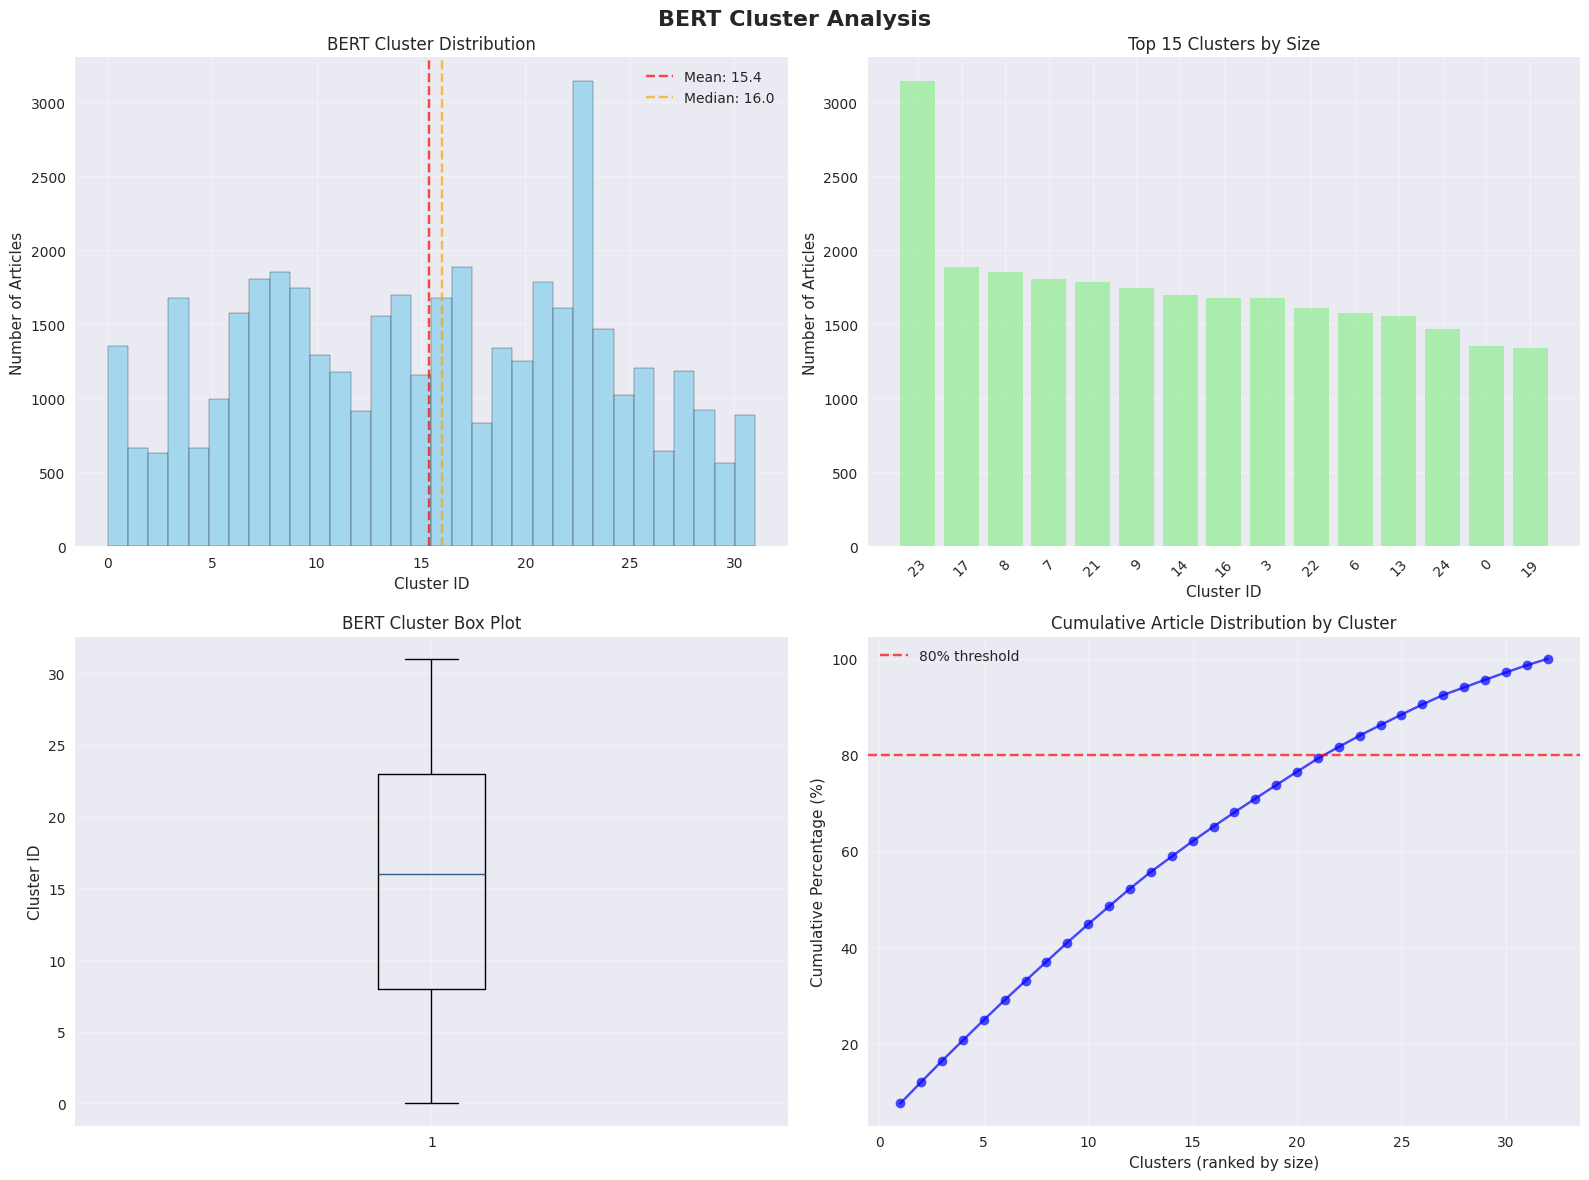


🔍 BERT Cluster Insights:
• Top 3 clusters contain: 16.3% of all valid articles
• Top 5 clusters contain: 24.8% of all valid articles
• Top 10 clusters contain: 44.8% of all valid articles
• Largest cluster: 3,147 articles
• Smallest cluster: 567 articles
• Size ratio (largest/smallest): 5.6x
• Cluster balance: Well-balanced (CV: 0.40)
• Total unique clusters: 32

📋 Data Quality Summary:
• Valid cluster assignments: 42,229 articles (99.8%)
• Missing cluster assignments: 69 articles (0.2%)
• Average articles per cluster: 1319.7


In [6]:
# BERT Cluster Distribution Analysis
print("📈 BERT Cluster Distribution Analysis")

# Focus specifically on bert_cluster feature
bert_cluster_feature = 'bert_cluster'

if bert_cluster_feature in df.columns:
    # Check for missing values first
    missing_clusters = df.select(pl.col(bert_cluster_feature).null_count()).item()
    total_articles = df.height
    
    if missing_clusters > 0:
        missing_pct = (missing_clusters / total_articles) * 100
        print(f"⚠️ Missing cluster assignments: {missing_clusters:,} articles ({missing_pct:.1f}%)")
        print("Proceeding with analysis on articles with valid cluster assignments...\n")
    
    # Filter out missing values for analysis
    df_valid_clusters = df.filter(pl.col(bert_cluster_feature).is_not_null())
    valid_count = df_valid_clusters.height
    
    # Calculate comprehensive statistics for BERT clusters (excluding nulls)
    stats_data = df_valid_clusters.select([
        pl.col(bert_cluster_feature).count().alias('count'),
        pl.col(bert_cluster_feature).mean().alias('mean'),
        pl.col(bert_cluster_feature).median().alias('median'),
        pl.col(bert_cluster_feature).std().alias('std'),
        pl.col(bert_cluster_feature).min().alias('min'),
        pl.col(bert_cluster_feature).max().alias('max'),
        pl.col(bert_cluster_feature).quantile(0.25).alias('Q1'),
        pl.col(bert_cluster_feature).quantile(0.75).alias('Q3'),
        pl.col(bert_cluster_feature).quantile(0.95).alias('P95'),
        pl.col(bert_cluster_feature).quantile(0.99).alias('P99')
    ]).to_dict(as_series=False)
    
    print(f"🎯 BERT CLUSTER STATISTICS (Valid assignments only):")
    for stat, value in stats_data.items():
        if stat == 'count':
            print(f"  {stat}: {value[0]:,}")
        else:
            print(f"  {stat}: {value[0]:.4f}")
    
    # BERT cluster distribution analysis (only valid clusters)
    cluster_distribution = (
        df_valid_clusters.group_by(bert_cluster_feature)
        .agg([
            pl.len().alias('article_count'),
            (pl.len() / valid_count * 100).alias('percentage')
        ])
        .sort(bert_cluster_feature)
    )
    
    print(f"\n📊 BERT Cluster Distribution:")
    print(f"Total valid clusters: {cluster_distribution.height}")
    print(f"Articles with valid clusters: {valid_count:,} ({valid_count/total_articles*100:.1f}%)")
    print(f"Articles per cluster:")
    
    cluster_pd = cluster_distribution.to_pandas()
    for _, row in cluster_pd.head(10).iterrows():  # Show first 10 clusters
        cluster_id = int(row[bert_cluster_feature])
        article_count = int(row['article_count'])
        percentage = row['percentage']
        print(f"  Cluster {cluster_id}: {article_count:,} articles ({percentage:.1f}%)")
    
    if cluster_distribution.height > 10:
        print(f"  ... and {cluster_distribution.height - 10} more clusters")
    
    # Create comprehensive BERT cluster visualisations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('BERT Cluster Analysis', fontsize=16, fontweight='bold')
    
    # Convert to pandas for plotting (valid clusters only)
    feature_data = df_valid_clusters.select(bert_cluster_feature).to_pandas()[bert_cluster_feature]
    
    # 1. Cluster distribution histogram
    n_unique_clusters = df_valid_clusters.select(pl.col(bert_cluster_feature).n_unique()).item()
    bins = min(32, n_unique_clusters)  # Use appropriate number of bins
    
    axes[0, 0].hist(feature_data, bins=bins, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0, 0].set_title('BERT Cluster Distribution')
    axes[0, 0].set_xlabel('Cluster ID')
    axes[0, 0].set_ylabel('Number of Articles')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add statistics annotation
    mean_val = feature_data.mean()
    median_val = feature_data.median()
    axes[0, 0].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.1f}')
    axes[0, 0].axvline(median_val, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_val:.1f}')
    axes[0, 0].legend()
    
    # 2. Cluster size bar chart (top 15 clusters)
    top_clusters = cluster_pd.nlargest(min(15, len(cluster_pd)), 'article_count')
    axes[0, 1].bar(top_clusters[bert_cluster_feature].astype(str), top_clusters['article_count'], 
                   alpha=0.7, color='lightgreen')
    axes[0, 1].set_title(f'Top {len(top_clusters)} Clusters by Size')
    axes[0, 1].set_xlabel('Cluster ID')
    axes[0, 1].set_ylabel('Number of Articles')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot for cluster distribution
    axes[1, 0].boxplot(feature_data, vert=True)
    axes[1, 0].set_title('BERT Cluster Box Plot')
    axes[1, 0].set_ylabel('Cluster ID')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Cumulative percentage plot
    cluster_sorted = cluster_pd.sort_values('article_count', ascending=False)
    cluster_sorted['cumulative_pct'] = cluster_sorted['percentage'].cumsum()
    
    axes[1, 1].plot(range(1, len(cluster_sorted) + 1), cluster_sorted['cumulative_pct'], 
                    'bo-', alpha=0.7)
    axes[1, 1].set_title('Cumulative Article Distribution by Cluster')
    axes[1, 1].set_xlabel('Clusters (ranked by size)')
    axes[1, 1].set_ylabel('Cumulative Percentage (%)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% threshold')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print(f"\n🔍 BERT Cluster Insights:")
    
    # Cluster concentration analysis
    top_3_clusters = cluster_sorted.head(3)['percentage'].sum()
    top_5_clusters = cluster_sorted.head(min(5, len(cluster_sorted)))['percentage'].sum()
    top_10_clusters = cluster_sorted.head(min(10, len(cluster_sorted)))['percentage'].sum()
    
    print(f"• Top 3 clusters contain: {top_3_clusters:.1f}% of all valid articles")
    if len(cluster_sorted) >= 5:
        print(f"• Top 5 clusters contain: {top_5_clusters:.1f}% of all valid articles")
    if len(cluster_sorted) >= 10:
        print(f"• Top 10 clusters contain: {top_10_clusters:.1f}% of all valid articles")
    
    # Cluster balance analysis
    cluster_sizes = cluster_pd['article_count'].values
    largest_cluster = cluster_sizes.max()
    smallest_cluster = cluster_sizes.min()
    size_ratio = largest_cluster / smallest_cluster if smallest_cluster > 0 else float('inf')
    
    print(f"• Largest cluster: {largest_cluster:,} articles")
    print(f"• Smallest cluster: {smallest_cluster:,} articles")
    print(f"• Size ratio (largest/smallest): {size_ratio:.1f}x")
    
    # Distribution characteristics
    cluster_cv = cluster_pd['article_count'].std() / cluster_pd['article_count'].mean()
    balance_assessment = "Well-balanced" if cluster_cv < 0.5 else "Moderately balanced" if cluster_cv < 1.0 else "Imbalanced"
    
    print(f"• Cluster balance: {balance_assessment} (CV: {cluster_cv:.2f})")
    print(f"• Total unique clusters: {n_unique_clusters}")
    
    # Data quality summary
    print(f"\n📋 Data Quality Summary:")
    print(f"• Valid cluster assignments: {valid_count:,} articles ({valid_count/total_articles*100:.1f}%)")
    if missing_clusters > 0:
        print(f"• Missing cluster assignments: {missing_clusters:,} articles ({missing_pct:.1f}%)")
    print(f"• Average articles per cluster: {valid_count/n_unique_clusters:.1f}")
    
else:
    print("❌ BERT cluster feature not found in the dataset.")

## 5. Text Embedding Features Analysis


In [7]:
# Text embedding features analysis
print("🤖 Text Embedding Features Analysis")

if text_embedding_features:
    print(f"Found {len(text_embedding_features)} text embedding features")
    
    # Categorise embedding types
    bert_features = [f for f in text_embedding_features if 'bert' in f.lower()]
    tfidf_features = [f for f in text_embedding_features if 'tfidf' in f.lower()]
    svd_features = [f for f in text_embedding_features if 'svd' in f.lower()]
    pca_features = [f for f in text_embedding_features if 'pca' in f.lower()]
    
    print(f"\n📊 Embedding Feature Categories:")
    print(f"• BERT features: {len(bert_features)}")
    print(f"• TF-IDF features: {len(tfidf_features)}")
    print(f"• SVD features: {len(svd_features)}")
    print(f"• PCA features: {len(pca_features)}")
    
    # Analyse embedding feature statistics
    sample_embeddings = text_embedding_features[:20]  # Sample for analysis
    
    if sample_embeddings:
        embedding_stats = []
        
        for feature in sample_embeddings:
            if feature in df.columns:
                stats = df.select([
                    pl.col(feature).mean().alias('mean'),
                    pl.col(feature).std().alias('std'),
                    pl.col(feature).min().alias('min'),
                    pl.col(feature).max().alias('max')
                ]).to_dict(as_series=False)
                
                embedding_stats.append({
                    'Feature': feature,
                    'Mean': f"{stats['mean'][0]:.4f}",
                    'Std': f"{stats['std'][0]:.4f}",
                    'Range': f"[{stats['min'][0]:.3f}, {stats['max'][0]:.3f}]"
                })
        
        embedding_df = pd.DataFrame(embedding_stats)
        print(f"\n📈 Sample Embedding Statistics:")
        print(embedding_df.head(10).to_string(index=False))
    
    # Visualise embedding feature distributions
    if len(sample_embeddings) >= 4:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        fig.suptitle('Text Embedding Features Distribution', fontsize=16, fontweight='bold')
        
        for i in range(4):
            if i < len(sample_embeddings):
                feature = sample_embeddings[i]
                if feature in df.columns:
                    feature_data = df.select(feature).to_pandas()[feature].dropna()
                    
                    axes[i].hist(feature_data, bins=50, alpha=0.7, edgecolor='black')
                    axes[i].set_title(f'{feature}')
                    axes[i].set_xlabel('Value')
                    axes[i].set_ylabel('Frequency')
                    axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Embedding space dimensionality analysis
    if len(text_embedding_features) > 10:
        print(f"\n🔍 Embedding Space Analysis:")
        
        # Sample embeddings for PCA analysis
        embedding_sample = text_embedding_features[:50]  # Use first 50 dimensions
        
        try:
            # Convert to pandas for PCA
            embedding_data = df.select(embedding_sample).to_pandas().fillna(0)
            
            # Perform PCA
            pca = PCA(n_components=min(10, len(embedding_sample)))
            pca_result = pca.fit_transform(embedding_data)
            
            # Plot explained variance
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Explained variance ratio
            ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
            ax1.set_title('PCA Explained Variance Ratio')
            ax1.set_xlabel('Principal Component')
            ax1.set_ylabel('Explained Variance Ratio')
            ax1.grid(True, alpha=0.3)
            
            # Cumulative explained variance
            cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
            ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
            ax2.set_title('Cumulative Explained Variance')
            ax2.set_xlabel('Number of Components')
            ax2.set_ylabel('Cumulative Explained Variance')
            ax2.grid(True, alpha=0.3)
            ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% Variance')
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
            
            print(f"  First 5 components explain {cumulative_variance[4]:.1%} of variance")
            print(f"  95% variance captured by {np.argmax(cumulative_variance >= 0.95) + 1} components")
            
        except Exception as e:
            print(f"  ❌ Error in PCA analysis: {e}")
            
else:
    print("❌ No text embedding features found in the dataset.")

🤖 Text Embedding Features Analysis
Found 1 text embedding features

📊 Embedding Feature Categories:
• BERT features: 1
• TF-IDF features: 0
• SVD features: 0
• PCA features: 0

📈 Sample Embedding Statistics:
     Feature    Mean    Std           Range
bert_cluster 15.3813 8.4756 [0.000, 31.000]


## 6. Feature Correlation Analysis


In [8]:
# Comprehensive feature correlation analysis
print("🔗 Feature Correlation Analysis")

# Re-define numeric features for correlation analysis
numeric_features = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
analysis_numeric_features = [col for col in numeric_features 
                           if col not in ['article_id'] and not col.endswith('_id')]

# Select features for correlation analysis (avoid too many embedding features)
correlation_features = []

# Add non-embedding numeric features
non_embedding_numeric = [f for f in analysis_numeric_features if f not in text_embedding_features]
correlation_features.extend(non_embedding_numeric[:10])  # Limit to 10

# Add sample of embedding features
if text_embedding_features:
    correlation_features.extend(text_embedding_features[:20])  # Sample 20 embedding features

print(f"Analysing correlations between {len(correlation_features)} features")
print(f"Features: {correlation_features}")

if len(correlation_features) > 1:
    # Calculate correlation matrix
    corr_data = df.select(correlation_features).to_pandas().fillna(0)
    correlation_matrix = corr_data.corr()
    
    # Create correlation heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True if len(correlation_features) <= 10 else False,  # Only annotate if few features
        cmap='RdBu_r',
        center=0,
        square=True,
        cbar_kws={'shrink': 0.8},
        ax=ax,
        fmt='.2f'
    )
    
    ax.set_title('Article Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify strongest correlations
    print("\n🔍 Strongest Feature Correlations (|r| > 0.3):")
    strong_correlations = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.3:  # Lower threshold since we have fewer features
                strong_correlations.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    # Sort by absolute correlation strength
    strong_correlations.sort(key=lambda x: abs(x['Correlation']), reverse=True)
    
    if strong_correlations:
        for corr in strong_correlations[:15]:  # Top 15
            print(f"  {corr['Feature 1']} ↔ {corr['Feature 2']}: {corr['Correlation']:.3f}")
    else:
        print("  No strong correlations (|r| > 0.3) found between features.")
        
    # Feature redundancy analysis
    highly_corr_pairs = [corr for corr in strong_correlations if abs(corr['Correlation']) > 0.7]
    
    if highly_corr_pairs:
        print(f"\n⚠️ Potentially Redundant Features ({len(highly_corr_pairs)} pairs with |r| > 0.7):")
        for corr in highly_corr_pairs[:10]:
            print(f"  {corr['Feature 1']} ↔ {corr['Feature 2']}: {corr['Correlation']:.3f}")
    else:
        print("\n✅ No highly redundant features found (|r| > 0.7)")
        
    # Summary of correlation analysis
    print(f"\n📊 Correlation Analysis Summary:")
    print(f"• Features analyzed: {len(correlation_features)}")
    print(f"• Strong correlations (|r| > 0.3): {len(strong_correlations)}")
    print(f"• Potentially redundant pairs (|r| > 0.7): {len(highly_corr_pairs)}")
    
    if len(correlation_features) == 1:
        print("\n📝 Note: Only one feature available for correlation analysis.")
        print("  BERT cluster feature shows the semantic grouping of articles.")
        
elif len(correlation_features) == 1:
    print(f"Only one feature available: {correlation_features[0]}")
    print("Cannot perform correlation analysis with a single feature.")
    print("\n📊 Single Feature Analysis:")
    
    feature = correlation_features[0]
    feature_stats = df.select([
        pl.col(feature).count().alias('count'),
        pl.col(feature).n_unique().alias('unique_values'),
        pl.col(feature).mean().alias('mean'),
        pl.col(feature).std().alias('std')
    ]).to_dict(as_series=False)
    
    for stat, value in feature_stats.items():
        if stat in ['count', 'unique_values']:
            print(f"  {stat}: {value[0]:,}")
        else:
            print(f"  {stat}: {value[0]:.4f}")
            
else:
    print("❌ No suitable features found for correlation analysis.")

🔗 Feature Correlation Analysis
Analysing correlations between 1 features
Features: ['bert_cluster']
Only one feature available: bert_cluster
Cannot perform correlation analysis with a single feature.

📊 Single Feature Analysis:
  count: 42,229
  unique_values: 33
  mean: 15.3813
  std: 8.4756


## 7. Article Clustering Analysis


In [9]:
# Article clustering analysis for product segmentation
print("🎯 Article Clustering Analysis")

# Prepare clustering features (use a mix of different feature types)
clustering_features = []

# Add non-embedding numeric features
if non_embedding_numeric:
    clustering_features.extend(non_embedding_numeric[:5])

# Add embedding features
if text_embedding_features:
    clustering_features.extend(text_embedding_features[:15])  # Sample embedding features

print(f"Using {len(clustering_features)} features for clustering: {clustering_features[:10]}...")

if len(clustering_features) >= 3:
    # Prepare clustering data
    cluster_data = df.select(clustering_features).to_pandas().fillna(0)
    
    # Standardise features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Determine optimal number of clusters using multiple methods
    max_k = min(15, df.height // 100)  # Reasonable upper bound
    k_range = range(2, max_k + 1)
    
    inertias = []
    silhouette_scores = []
    
    print(f"\n🔍 Evaluating cluster numbers from 2 to {max_k}...")
    
    for k in k_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_data)
        
        # Calculate metrics
        inertias.append(kmeans.inertia_)
        
        # Silhouette score (sample for large datasets)
        if len(scaled_data) > 5000:
            sample_indices = np.random.choice(len(scaled_data), 5000, replace=False)
            sil_score = silhouette_score(scaled_data[sample_indices], cluster_labels[sample_indices])
        else:
            sil_score = silhouette_score(scaled_data, cluster_labels)
        
        silhouette_scores.append(sil_score)
    
    # Plot clustering evaluation metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elbow curve
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_title('Elbow Method for Optimal K')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_title('Silhouette Score by Number of Clusters')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Select optimal K (highest silhouette score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    best_silhouette = max(silhouette_scores)
    
    print(f"\n🎯 Optimal number of clusters: {optimal_k} (Silhouette Score: {best_silhouette:.3f})")
    
    # Perform final clustering
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    final_clusters = final_kmeans.fit_predict(scaled_data)
    
    # Cluster analysis
    cluster_df = df.select(['article_id'] + clustering_features).to_pandas()
    cluster_df['cluster'] = final_clusters
    
    print(f"\n📊 Article Cluster Analysis (K={optimal_k}):")
    print("=" * 50)
    
    cluster_summary = []
    
    for cluster_id in range(optimal_k):
        cluster_mask = final_clusters == cluster_id
        cluster_size = np.sum(cluster_mask)
        cluster_percentage = (cluster_size / len(final_clusters)) * 100
        
        cluster_summary.append({
            'Cluster': cluster_id,
            'Size': cluster_size,
            'Percentage': cluster_percentage
        })
        
        print(f"\n📦 CLUSTER {cluster_id}: {cluster_size:,} articles ({cluster_percentage:.1f}%)")
        
        # Calculate cluster characteristics for non-embedding features
        segment_data = cluster_df[cluster_df['cluster'] == cluster_id]
        
        for feature in non_embedding_numeric[:5]:  # Show top 5 features
            if feature in segment_data.columns:
                mean_val = segment_data[feature].mean()
                overall_mean = cluster_df[feature].mean()
                
                if not np.isnan(mean_val) and not np.isnan(overall_mean) and overall_mean != 0:
                    difference = ((mean_val - overall_mean) / overall_mean) * 100
                    
                    if abs(difference) > 10:  # Only show significant differences
                        direction = "above" if difference > 0 else "below"
                        print(f"  • {feature}: {mean_val:.3f} ({abs(difference):.0f}% {direction} average)")
    
    # Visualise clusters using PCA
    if len(clustering_features) > 2:
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(scaled_data)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], c=final_clusters, cmap='viridis', alpha=0.6, s=20)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        ax.set_title(f'Article Clusters Visualisation (K={optimal_k}, PCA Projection)')
        plt.colorbar(scatter, label='Cluster')
        plt.tight_layout()
        plt.show()
        
        print(f"\n📈 PCA explains {pca.explained_variance_ratio_.sum():.1%} of total variance")
    
    # Suggest cluster interpretations based on categorical features
    if categorical_features:
        print(f"\n🏷️ Cluster Interpretation (based on categorical features):")
        
        for cluster_id in range(min(optimal_k, 5)):  # Show first 5 clusters
            cluster_articles = df.filter(pl.col('article_id').is_in(
                cluster_df[cluster_df['cluster'] == cluster_id]['article_id'].tolist()
            ))
            
            print(f"\n  CLUSTER {cluster_id}:")
            
            for cat_feature in categorical_features[:3]:  # Top 3 categorical features
                if cat_feature in cluster_articles.columns:
                    top_categories = (
                        cluster_articles.group_by(cat_feature)
                        .count()
                        .sort('count', descending=True)
                        .head(3)
                    )
                    
                    print(f"    Top {cat_feature}: ", end="")
                    for row in top_categories.iter_rows(named=True):
                        pct = (row['count'] / cluster_articles.height) * 100
                        print(f"{row[cat_feature]} ({pct:.0f}%), ", end="")
                    print()  # New line
    
else:
    print("❌ Insufficient features for meaningful clustering analysis.")

🎯 Article Clustering Analysis
Using 1 features for clustering: ['bert_cluster']...
❌ Insufficient features for meaningful clustering analysis.


## 8. Interactive Visualisations


In [10]:
# Create interactive visualisations using Plotly
print("📊 Interactive Article Analytics")

# Interactive categorical feature distribution
if categorical_features:
    for feature in categorical_features[:2]:  # Show first 2 categorical features
        if feature in df.columns:
            # Get category counts
            category_counts = (
                df.group_by(feature)
                .count()
                .sort('count', descending=True)
                .head(20)  # Top 20 categories
                .to_pandas()
            )
            
            # Create interactive bar chart
            fig = px.bar(
                category_counts,
                x=feature,
                y='count',
                title=f'Interactive {feature.replace("_", " ").title()} Distribution',
                hover_data=['count']
            )
            
            fig.update_layout(
                xaxis_tickangle=-45,
                height=500,
                showlegend=False
            )
            
            fig.show()

# Interactive correlation heatmap (subset of features)
if len(correlation_features) > 2:
    # Use subset for interactive visualisation
    subset_features = correlation_features[:15]  # First 15 features
    corr_subset = df.select(subset_features).to_pandas().fillna(0).corr()
    
    fig_corr = px.imshow(
        corr_subset,
        text_auto=True,
        aspect="auto",
        title="Interactive Article Feature Correlation Matrix",
        color_continuous_scale='RdBu_r',
        color_continuous_midpoint=0
    )
    
    fig_corr.update_layout(height=600)
    fig_corr.show()

# Interactive 3D cluster visualisation
if 'final_clusters' in locals() and len(clustering_features) >= 3:
    # Sample data for performance
    sample_size = min(2000, df.height)
    sample_indices = np.random.choice(df.height, sample_size, replace=False)
    
    sample_data = cluster_df.iloc[sample_indices].copy()
    
    if len(clustering_features) >= 3:
        fig_3d = px.scatter_3d(
            sample_data,
            x=clustering_features[0],
            y=clustering_features[1],
            z=clustering_features[2],
            color='cluster',
            title='Interactive 3D Article Clustering View',
            hover_data=['article_id'],
            color_continuous_scale='viridis'
        )
        
        fig_3d.update_layout(height=600)
        fig_3d.show()

# Interactive embedding space visualisation (if available)
if text_embedding_features and len(text_embedding_features) >= 2:
    # Use first two embedding dimensions
    embed_sample = df.select(['article_id'] + text_embedding_features[:2]).to_pandas().sample(
        min(1000, df.height)
    )
    
    fig_embed = px.scatter(
        embed_sample,
        x=text_embedding_features[0],
        y=text_embedding_features[1],
        title='Interactive Embedding Space Visualisation',
        hover_data=['article_id'],
        opacity=0.6
    )
    
    fig_embed.update_layout(height=500)
    fig_embed.show()

📊 Interactive Article Analytics


## 9. Article Insights and Recommendations


In [11]:
# Generate comprehensive article insights and recommendations
print("💡 Article Features Insights and Recommendations")
print("=" * 60)

# Basic dataset statistics
total_articles = df.height
total_features = df.width
complete_articles = df.filter(pl.all_horizontal(pl.all().is_not_null())).height

print("🎯 DATASET OVERVIEW:")
print(f"• Total Articles: {total_articles:,}")
print(f"• Total Features: {total_features}")
print(f"• Complete Records: {complete_articles:,} ({complete_articles/total_articles*100:.1f}%)")
print(f"• Feature Categories: {len(categorical_features)} categorical, {len(analysis_numeric_features)} numeric, {len(text_embedding_features)} embeddings")

# Categorical feature diversity
if categorical_features:
    print("\n🏷️ PRODUCT CATALOGUE DIVERSITY:")
    
    for feature in categorical_features:
        if feature in df.columns:
            unique_count = df.select(pl.col(feature).n_unique()).item()
            diversity_ratio = unique_count / total_articles
            
            print(f"• {feature.replace('_', ' ').title()}: {unique_count} unique values (diversity: {diversity_ratio:.1%})")
            
            # Category concentration analysis
            top_category_share = (
                df.group_by(feature)
                .count()
                .sort('count', descending=True)
                .head(1)
                .select((pl.col('count') / total_articles * 100).alias('percentage'))
                .item()
            )
            
            concentration = "High" if top_category_share > 50 else "Medium" if top_category_share > 25 else "Low"
            print(f"  Concentration: {concentration} (top category: {top_category_share:.1f}% of articles)")

# Feature engineering quality assessment
if text_embedding_features:
    print("\n🤖 FEATURE ENGINEERING QUALITY:")
    
    # Embedding feature statistics
    embedding_sample = text_embedding_features[:20]
    
    if embedding_sample:
        # Calculate average variance across embedding dimensions
        embedding_data = df.select(embedding_sample).to_pandas().fillna(0)
        avg_variance = embedding_data.var().mean()
        avg_std = embedding_data.std().mean()
        
        print(f"• Embedding Features: {len(text_embedding_features)} dimensions")
        print(f"• Average Variance: {avg_variance:.4f}")
        print(f"• Average Standard Deviation: {avg_std:.4f}")
        
        # Feature redundancy assessment
        if 'strong_correlations' in locals():
            high_corr_count = len([c for c in strong_correlations if abs(c['Correlation']) > 0.8])
            redundancy_level = "High" if high_corr_count > 10 else "Medium" if high_corr_count > 5 else "Low"
            print(f"• Feature Redundancy: {redundancy_level} ({high_corr_count} highly correlated pairs)")

# Clustering insights
if 'optimal_k' in locals():
    print("\n🎯 PRODUCT SEGMENTATION INSIGHTS:")
    print(f"• Optimal Clusters: {optimal_k} distinct product segments")
    print(f"• Clustering Quality: {best_silhouette:.3f} silhouette score")
    
    # Cluster balance analysis
    if 'cluster_summary' in locals():
        cluster_sizes = [c['Size'] for c in cluster_summary]
        size_std = np.std(cluster_sizes)
        size_mean = np.mean(cluster_sizes)
        balance_ratio = size_std / size_mean
        
        balance_level = "Well-balanced" if balance_ratio < 0.5 else "Moderately balanced" if balance_ratio < 1.0 else "Imbalanced"
        print(f"• Cluster Balance: {balance_level} (CV: {balance_ratio:.2f})")
        
        largest_cluster = max(cluster_sizes)
        smallest_cluster = min(cluster_sizes)
        print(f"• Size Range: {smallest_cluster:,} - {largest_cluster:,} articles per cluster")

# Strategic recommendations
print("\n🎯 STRATEGIC RECOMMENDATIONS:")

# Product catalogue recommendations
if categorical_features:
    for feature in categorical_features:
        if feature in df.columns:
            unique_count = df.select(pl.col(feature).n_unique()).item()
            
            if unique_count < 10:
                print(f"• 📈 Consider expanding {feature.replace('_', ' ')} variety (only {unique_count} categories)")
            elif unique_count > 100:
                print(f"• 🎯 Consider consolidating {feature.replace('_', ' ')} categories ({unique_count} may be too many)")

# Feature engineering recommendations
if text_embedding_features:
    if len(text_embedding_features) > 100:
        print("• 🔧 Consider dimensionality reduction for embedding features (current: {} dimensions)".format(len(text_embedding_features)))
        print("  - Apply PCA or t-SNE for visualisation")
        print("  - Use feature selection techniques")
    
    if 'high_corr_count' in locals() and high_corr_count > 10:
        print("• ⚡ Address feature redundancy to improve model efficiency")
        print("  - Remove highly correlated features")
        print("  - Apply regularisation techniques")

# Clustering-based recommendations
if 'optimal_k' in locals():
    print(f"• 🛍️ Leverage {optimal_k} product segments for:")
    print("  - Targeted marketing campaigns")
    print("  - Inventory management optimisation")
    print("  - Product recommendation systems")
    print("  - Pricing strategy development")
    
    if 'balance_level' in locals() and 'Imbalanced' in balance_level:
        print("• ⚖️ Address cluster imbalance for better segmentation")
        print("  - Investigate dominant clusters")
        print("  - Consider alternative clustering algorithms")
        print("  - Apply stratified sampling for analysis")

print("\n📊 ANALYTICS RECOMMENDATIONS:")
print("• Implement automated article similarity scoring")
print("• Develop product performance tracking by cluster")
print("• Create embedding-based product search functionality")
print("• Set up monitoring for catalogue diversity metrics")
print("• Build recommendation engines using article features")

print("\n🔍 DATA QUALITY RECOMMENDATIONS:")
if complete_articles / total_articles < 0.95:
    print("• 🚨 Improve data completeness - missing values detected")
    print("  - Implement data validation pipelines")
    print("  - Add imputation strategies for missing features")

print("• Regular feature quality audits")
print("• Monitor embedding feature drift over time")
print("• Validate clustering stability with new data")

print("\n🎉 ANALYSIS COMPLETE")
print(f"✅ Analysed {total_articles:,} article records")
print(f"✅ Processed {total_features} engineered features")
print(f"✅ Identified product segments and patterns")
print(f"✅ Generated actionable recommendations")

💡 Article Features Insights and Recommendations
🎯 DATASET OVERVIEW:
• Total Articles: 42,298
• Total Features: 14
• Complete Records: 42,229 (99.8%)
• Feature Categories: 11 categorical, 1 numeric, 1 embeddings

🏷️ PRODUCT CATALOGUE DIVERSITY:
• Product Type Name: 124 unique values (diversity: 0.3%)
  Concentration: Low (top category: 11.5% of articles)
• Product Group Name: 18 unique values (diversity: 0.0%)
  Concentration: Medium (top category: 37.0% of articles)
• Graphical Appearance Name: 30 unique values (diversity: 0.1%)
  Concentration: High (top category: 51.8% of articles)
• Colour Group Name: 50 unique values (diversity: 0.1%)
  Concentration: Low (top category: 23.8% of articles)
• Perceived Colour Value Name: 8 unique values (diversity: 0.0%)
  Concentration: Medium (top category: 39.7% of articles)
• Perceived Colour Master Name: 20 unique values (diversity: 0.0%)
  Concentration: Low (top category: 23.8% of articles)
• Department Name: 238 unique values (diversity: 0.6%